In [19]:
import IO
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliankraus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliankraus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
df = IO.load_excel("./data/generated_examinations.xlsx")

In [21]:
do_not_split = [
    "li.",
    "bds.",
    "med.",
    "neg.",
    "lat.",
    'pos.',
    "re.",
    "mm, links",
    "mm, rechts",
    "mm, li",
    "mm, re",
    "o.B",
    "mm, verletzt",
    "mm, Seitendifferenz",
    "diskr."
]
def custom_split(text):
    for exception in do_not_split:
        text = re.sub(re.escape(exception), re.sub(r'[^\w\s]', '', exception), text, flags=re.IGNORECASE)
    parts = re.split(r'[.,]|\sund\s', text)
    parts = [part.strip() for part in parts if part.strip()]
    return parts

In [22]:
split_examinations = df['Text_Bef'].apply(custom_split).sum()

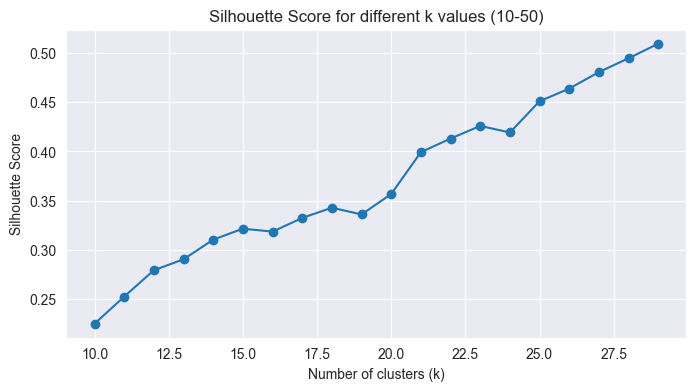

In [23]:
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(split_examinations)

# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
k_values = range(10, 30)  # Focus on the 10 to 50 range

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different k values (10-50)')
plt.show()
silhouette_data = pd.DataFrame({'Number of Clusters (k)': k_values, 'Silhouette Score': silhouette_scores})

# Save the DataFrame to a CSV file for easy import into a LaTeX document
silhouette_csv_path = "./data/silhouette_scores.csv"
silhouette_data.to_csv(silhouette_csv_path, index=False)
# Choose the best k from the focused range
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

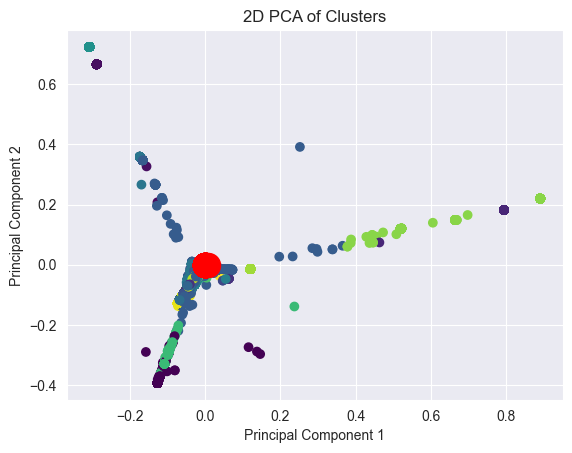

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming X is your dataset and kmeans is the fitted KMeans instance
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Clusters')
plt.show()


ValueError: x and y must have same first dimension, but have shapes (10,) and (99,)

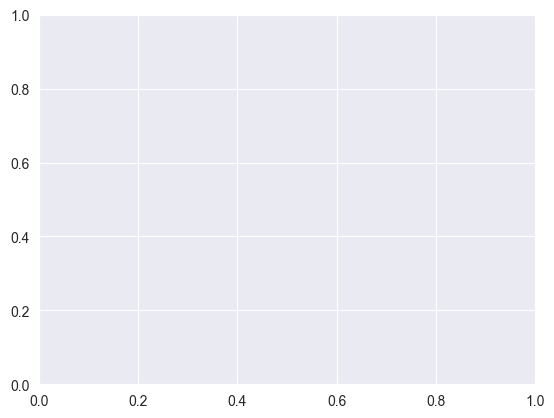

In [29]:
wcss = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


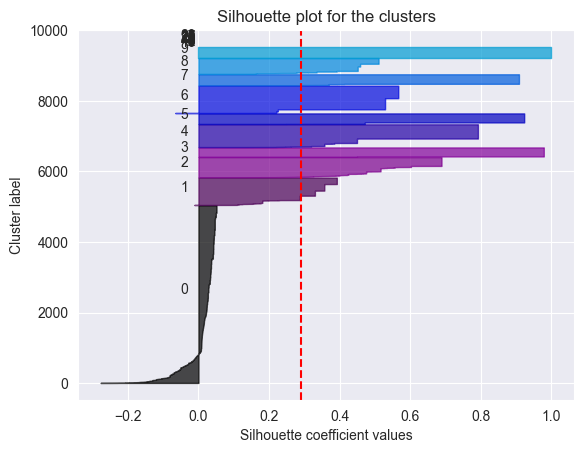

In [26]:
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

silhouette_values = silhouette_samples(X, kmeans.labels_)
y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / optimal_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title("Silhouette plot for the clusters")
plt.axvline(x=silhouette_values.mean(), color="red", linestyle="--")
plt.show()


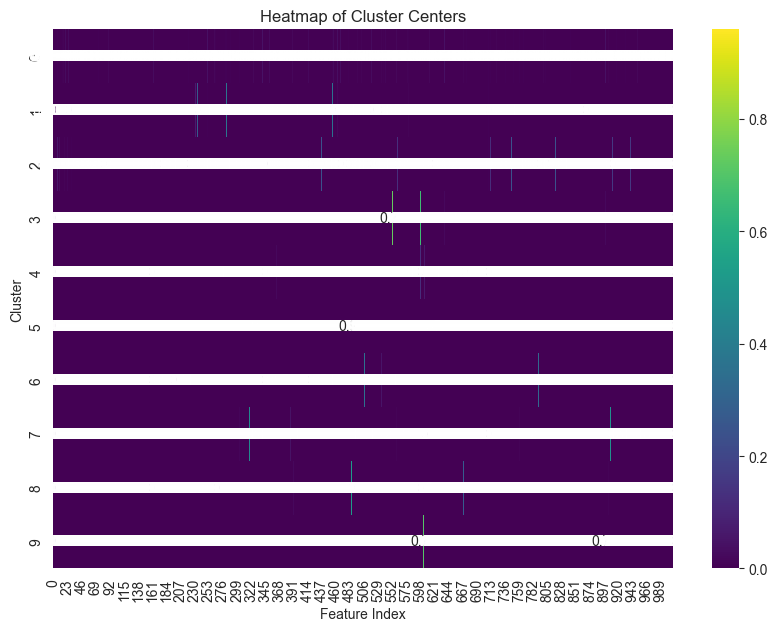

In [27]:
import seaborn as sns

# Assuming X is your dataset and kmeans is the fitted KMeans instance
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 7))
sns.heatmap(cluster_centers, annot=True, cmap='viridis')
plt.title('Heatmap of Cluster Centers')
plt.xlabel('Feature Index')
plt.ylabel('Cluster')
plt.show()


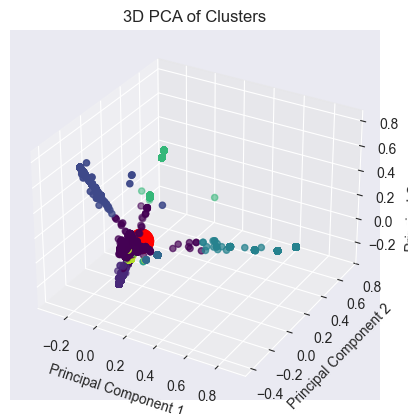

In [28]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
principal_components = pca.fit_transform(X.toarray())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=kmeans.labels_, cmap='viridis')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Clusters')
plt.show()


In [16]:
cluster_data = pd.DataFrame({'Text': split_examinations, 'Cluster': clusters})
cluster_data_sorted = cluster_data.sort_values('Cluster')
clusters_dict = {cluster: cluster_data_sorted[cluster_data_sorted['Cluster'] == cluster]['Text'].values.tolist() for cluster in cluster_data_sorted['Cluster'].unique()}
clusters_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in clusters_dict.items()]))

# Save the DataFrame to an Excel file
clusters_df.to_excel("./data/clustered_examinations.xlsx", index=False)

print("Data saved to clustered_examinations.xlsx")

Data saved to clustered_examinations.xlsx
